## Motivation
To be honest, I was a bit out of my wheelhouse when reading "Exponential Time Differencing for Stiff Systems" by Cox and Matthews. I should build some fundamentals first lol.

## Spectral Derivatives and FFT
Recall the Fast Fourier Transform algorithm that can compute the Fourier Transform of a function based on a sample of a points (aka Discrete Fourier Transform).

The Fourier Transform of a continuous function $f(x)$ is defined below
$$
  F\{f\}(k) = \hat{f}(k) = \int_{-\infty}^{\infty}f(x)e^{-ikx}dx
$$
Intuitvely, we are translating our inputs in time/space to frequency, re-building our function out of a series of waves.

On a computer, we can only store discrete points that compose our function. Suppose we have $N$ equally spaced out samples of $f(x)$
$$
x_j = \frac{2\pi j}{N}, j = 0,...,N-1
$$

The DFT is

$$
\hat{f}_k = \sum_{j=0}^{N-1} f_j\, e^{-2\pi i j k / N},
\qquad k = 0,\dots ,N-1
$$

## But how does this relate to derivatives?
The continuous fourier transform has an interesting property
$$
F(\frac{df}{dx}) = ikF(f)
$$
If we let $\text{fft}$ be our FFT and $\text{ifft}$ be the inverse FFT we find that after applying this property to our DFT we get
$$
f'(x_j) = \text{ifft}(ik \cdot \text{fft}(f_j)
$$

*But why would we ever need this? Are FDMs not enough?*
It turns out that its very useful for manipulating complex PDEs like the KS equation, and compared to finite difference methods the error gets smaller as the samples grow.

Let's get to coding!


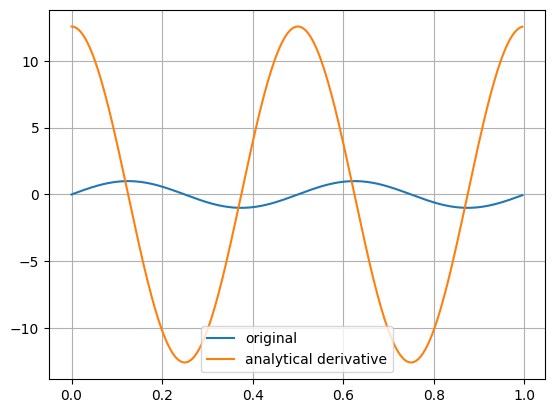

In [53]:
import numpy as np
import matplotlib.pyplot as plt

#
L = 1.0
N = 256
mesh_1d = np.linspace(0,L,N, endpoint=False)

def f(x):
  return np.sin(4 * np.pi * x)

def f_prime(x):
  return 4 * np.pi * np.cos(4 * np.pi * x)

f_h = f(mesh_1d)
f_prime_h = f_prime(mesh_1d)

plt.plot(mesh_1d, f_h, label="original")
plt.plot(mesh_1d, f_prime_h, label="analytical derivative")
plt.grid()
plt.legend()

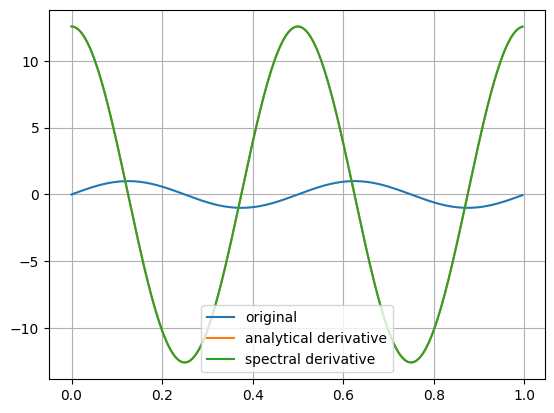

In [54]:
k = np.fft.fftfreq(N, d=L/(N * 2 * np.pi))
f_prime_fft_h = np.fft.ifft(1j * k * np.fft.fft(f_h)).real

plt.plot(mesh_1d, f_h, label="original")
plt.plot(mesh_1d, f_prime_h, label="analytical derivative")
plt.plot(mesh_1d, f_prime_fft_h, label="spectral derivative")
plt.grid()
plt.legend()

## Now what about in 2D?
Yes, the same idea applies, except now we deal in partial derivatives and frequency vectors.
$$
\nabla{f(\vec{x})} = \text{ifft2}(i\vec{k} \odot \text{fft2}(f(\vec{x}))
$$

(<Figure size 1500x500 with 4 Axes>,
 array([<Axes: xlabel='$x_0$', ylabel='$x_1$'>,
        <Axes: xlabel='$x_0$', ylabel='$x_1$'>,
        <Axes: xlabel='$x_0$', ylabel='$x_1$'>], dtype=object))

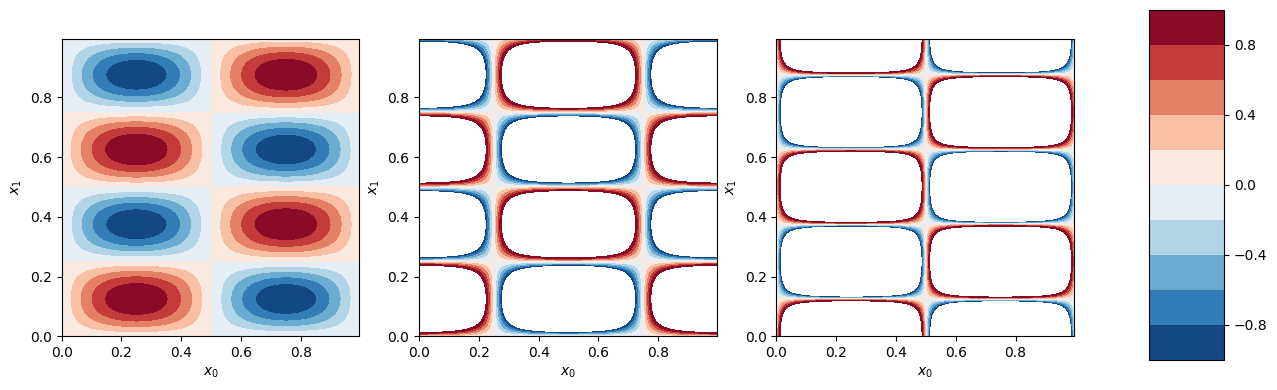

In [60]:
X, Y = np.meshgrid(mesh_1d, mesh_1d)
mesh_2d = np.stack((X, Y))

def f(x):
  return np.sin(2 * np.pi * x[0]) * np.sin(4 * np.pi * x[1])

def f_x0(x):
  return 2 * np.pi * np.cos(2 * np.pi * x[0]) * np.sin(4 * np.pi * x[1])

def f_x1(x):
  return np.sin(2 * np.pi * x[0]) * 4 * np.pi * np.cos(4 * np.pi * x[1])

f_h = f(mesh_2d)
f_x0_h = f_x0(mesh_2d)
f_x1_h = f_x1(mesh_2d)

def plot_contour_row(*fields, levels=np.linspace(-1, 1, 11), cmap="RdBu_r"):
    fig, axes = plt.subplots(1, len(fields), figsize=(5*len(fields), 5))
    for ax, field in zip(axes, fields):
        a = ax.contourf(X, Y, field, levels=levels, cmap=cmap)
        ax.set_aspect("equal")
        ax.set_xlabel("$x_0$")
        ax.set_ylabel("$x_1$")

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(a, cax=cbar_ax)

    return fig, axes

plot_contour_row(f_h, f_x0_h, f_x1_h)

In [61]:
wavenumbers_1d_real = np.fft.rfftfreq(N, d=1/N) * 2 * np.pi / L
wavenumbers_1d_full = np.fft.fftfreq(N, d=1/N) * 2 * np.pi / L
KX, KY = np.meshgrid(wavenumbers_1d_real, wavenumbers_1d_full)
wavenumbers = np.stack((KX, KY))

# Expected shape: (2, N, N//2+1)
# 2 for the two components KX and KY
# N for the full N frequencies in the y-direction
# (N//2) + 1 for the frequencies in the x-direction because rfft2 exploits conjugate symmetry
# Conjugate symmetry property tells us that the real signal reversed in time equals the complex conjugate of the original signal
wavenumbers.shape

(2, 256, 129)

(<Figure size 1000x500 with 3 Axes>,
 array([<Axes: xlabel='$x_0$', ylabel='$x_1$'>,
        <Axes: xlabel='$x_0$', ylabel='$x_1$'>], dtype=object))

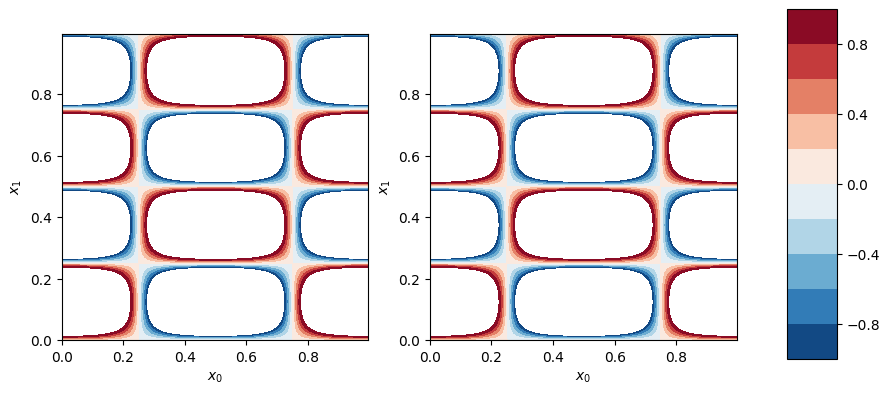

In [62]:
derivative_operator = 1j * wavenumbers #1j is the imaginary unit in Python

# Partial derivative for x0
f_x0_h_spectrally = np.fft.irfft2(
    derivative_operator[0] * np.fft.rfft2(f_h),
    s=(N, N),
)

plot_contour_row(f_x0_h, f_x0_h_spectrally)

(<Figure size 1000x500 with 3 Axes>,
 array([<Axes: xlabel='$x_0$', ylabel='$x_1$'>,
        <Axes: xlabel='$x_0$', ylabel='$x_1$'>], dtype=object))

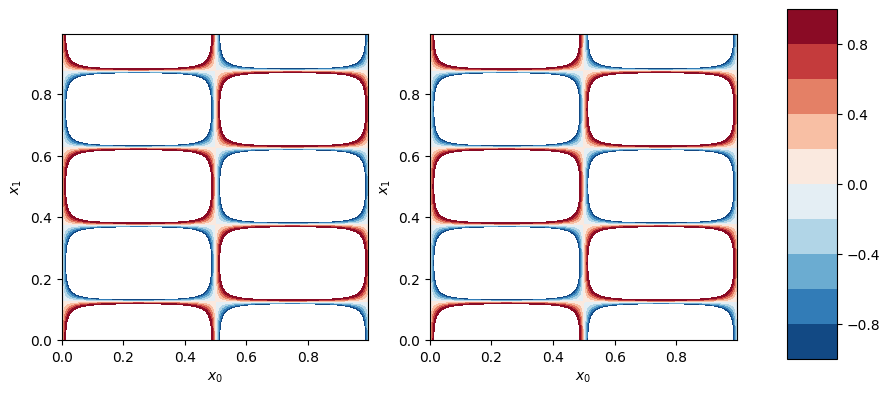

In [63]:
# Partial derivative for x1
f_x1_h_spectrally = np.fft.irfft2(
    derivative_operator[1] * np.fft.rfft2(f_h),
    s=(N, N),
)

plot_contour_row(f_x1_h, f_x1_h_spectrally)

In [64]:
np.linalg.norm(f_x0_h_spectrally - f_x0_h) / np.linalg.norm(f_x0_h) # Error of about 

np.float64(1.551883567943506e-14)

#### Notes
- While debugging, I found that if I made L something that would cut the period off (e.g., like 2pi ~= 6.28 cycles), the accuracy is wildly off (72% relative error)
- Enter, spectral leakage (FFT assumes our function is periodic!).
- Spectral leakage == a signal's frequency doesn't exactly match one of the discrete frequency "bins" that the FFT can represent